**PySpark task**

Dataset:

The dataset provides a snapshot of a sample Netflix userbase,
showcasing various aspects of user subscriptions, revenue, account
details, and activity. Each row represents a unique user, identified by their
User ID. The dataset includes information such as the user&#39;s subscription
type (Basic, Standard, or Premium), the monthly revenue generated from
their subscription, the date they joined Netflix (Join Date), the date of their
last payment (Last Payment Date), and the country in which they are
located.

Additional columns have been included to provide insights into user
behavior and preferences. These columns include Device Type (e.g.,
Smart TV, Mobile, Desktop, Tablet) and Account Status (whether the
account is active or not). The dataset serves as a synthetic
representation and does not reflect actual Netflix user data. It can be
used for analysis and modeling to understand user trends, preferences,
and revenue generation within a hypothetical Netflix userbase.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=151f00575a57f5cd56ceaa3deba114b651a2838d2397d97d399bd003d0987f5f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import os

In [4]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [5]:
import findspark

In [6]:
  findspark.init()
  from pyspark.sql import SparkSession
  spark = SparkSession.builder.master("local").getOrCreate()
  spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
  spark

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
import  pyspark.sql.functions as fn
import findspark
from pyspark.sql.functions import col
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date
from pyspark.sql.functions import sum

In [10]:
netflix_df=spark.read.csv("/content/Netflix.csv", header=True, inferSchema=True)

In [12]:
netflix_df.head

<bound method DataFrame.head of +-------+-----------------+---------------+---------+-----------------+--------------+---+------+----------+-------------+
|User ID|Subscription Type|Monthly Revenue|Join Date|Last Payment Date|       Country|Age|Gender|    Device|Plan Duration|
+-------+-----------------+---------------+---------+-----------------+--------------+---+------+----------+-------------+
|      1|            Basic|             10| 15-01-22|         10-06-23| United States| 28|  Male|Smartphone|      1 Month|
|      2|          Premium|             15| 05-09-21|         22-06-23|        Canada| 35|Female|    Tablet|      1 Month|
|      3|         Standard|             12| 28-02-23|         27-06-23|United Kingdom| 42|  Male|  Smart TV|      1 Month|
|      4|         Standard|             12| 10-07-22|         26-06-23|     Australia| 51|Female|    Laptop|      1 Month|
|      5|            Basic|             10| 01-05-23|         28-06-23|       Germany| 33|  Male|Smartphone

In [15]:
netflix_df.columns

['User ID',
 'Subscription Type',
 'Monthly Revenue',
 'Join Date',
 'Last Payment Date',
 'Country',
 'Age',
 'Gender',
 'Device',
 'Plan Duration']

In [14]:
netflix_df.printSchema()

root
 |-- User ID: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Monthly Revenue: integer (nullable = true)
 |-- Join Date: string (nullable = true)
 |-- Last Payment Date: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Device: string (nullable = true)
 |-- Plan Duration: string (nullable = true)



In [16]:
netflix_df.describe().show()

+-------+-----------------+-----------------+------------------+---------+-----------------+-------------+-----------------+------+------+-------------+
|summary|          User ID|Subscription Type|   Monthly Revenue|Join Date|Last Payment Date|      Country|              Age|Gender|Device|Plan Duration|
+-------+-----------------+-----------------+------------------+---------+-----------------+-------------+-----------------+------+------+-------------+
|  count|             2500|             2500|              2500|     2500|             2500|         2500|             2500|  2500|  2500|         2500|
|   mean|           1250.5|             null|           12.5084|     null|             null|         null|          38.7956|  null|  null|         null|
| stddev|721.8321596234589|             null|1.6868513944775387|     null|             null|         null|7.171777631644684|  null|  null|         null|
|    min|                1|            Basic|                10| 01-03-22|        

In [17]:
netflix_df = netflix_df.na.drop()

In [19]:
netflix_df.describe().show()

+-------+-----------------+-----------------+------------------+---------+-----------------+-------------+-----------------+------+------+-------------+
|summary|          User ID|Subscription Type|   Monthly Revenue|Join Date|Last Payment Date|      Country|              Age|Gender|Device|Plan Duration|
+-------+-----------------+-----------------+------------------+---------+-----------------+-------------+-----------------+------+------+-------------+
|  count|             2500|             2500|              2500|     2500|             2500|         2500|             2500|  2500|  2500|         2500|
|   mean|           1250.5|             null|           12.5084|     null|             null|         null|          38.7956|  null|  null|         null|
| stddev|721.8321596234589|             null|1.6868513944775387|     null|             null|         null|7.171777631644684|  null|  null|         null|
|    min|                1|            Basic|                10| 01-03-22|        

In [24]:
# Convert 'Join Date' to datetime
netflix_df = netflix_df.withColumn("Join Date", to_date(col("Join Date"), "dd-MM-yy").cast(DateType()))
# Convert 'Last Payment Date' to datetime
netflix_df = netflix_df.withColumn("Last Payment Date", to_date(col("Last Payment Date"), "dd-MM-yy").cast(DateType()))
netflix_df.printSchema()


root
 |-- User ID: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Monthly Revenue: integer (nullable = true)
 |-- Join Date: date (nullable = true)
 |-- Last Payment Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Device: string (nullable = true)
 |-- Plan Duration: string (nullable = true)



# Insight 1: Subscription Type Distribution

From the bar plot, we see the distribution of subscription types among the users:


Basic: 999 users

Standard: 768 users

Premium: 733 users

This shows that the Basic plan is the most popular among the users, followed by Standard and then Premium.


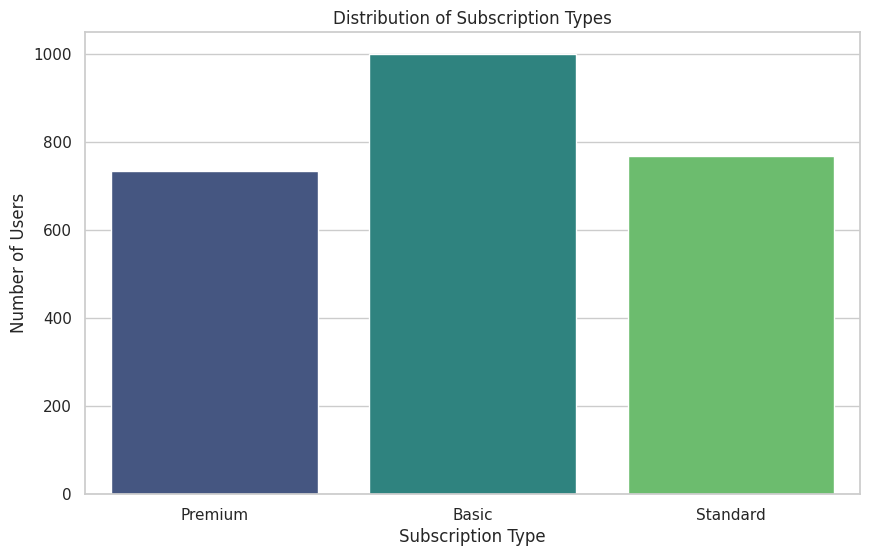

In [26]:
subscription_type_counts = netflix_df.groupBy("Subscription Type").count().toPandas()
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Subscription Type", y="count", data=subscription_type_counts, palette="viridis")
plt.title('Distribution of Subscription Types')
plt.xlabel('Subscription Type')
plt.ylabel('Number of Users')
plt.show()


# Insight 2: Revenue Generation by Subscription Type
The total monthly revenue by subscription type is:

Basic: $12,469

Standard: $9,573

Premium: $9,229

the Basic plan is the least expensive, it generates the highest revenue, likely due to its popularity and higher number of subscribers.

On the other hand, the Premium plan, despite having a higher cost per user, contributes less to the total revenue than the Basic plan, suggesting fewer subscribers.

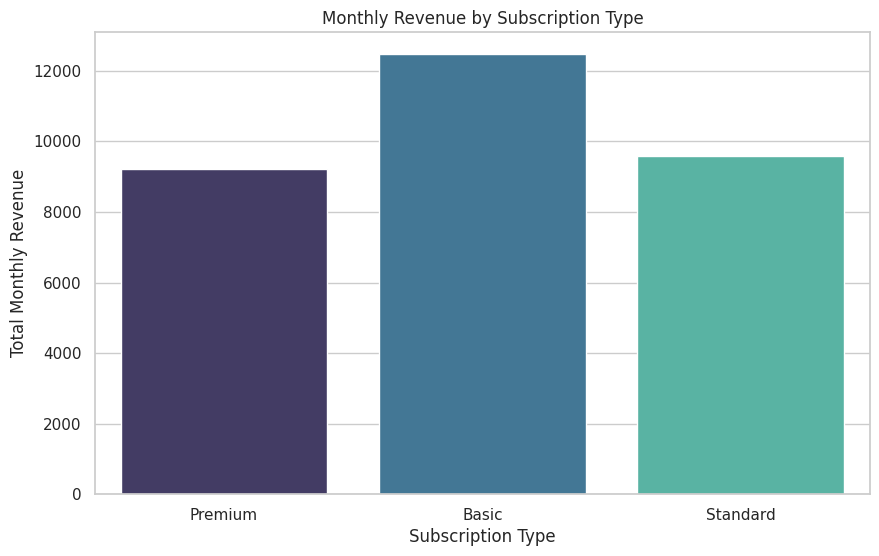

In [27]:
# Group by Subscription Type and calculate sum of Monthly Revenue
revenue_by_subscription = netflix_df.groupBy('Subscription Type').agg(sum('Monthly Revenue').alias('Total Monthly Revenue'))
revenue_by_subscription_pd = revenue_by_subscription.toPandas()
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Subscription Type", y="Total Monthly Revenue", data=revenue_by_subscription_pd, palette="mako")
plt.title('Monthly Revenue by Subscription Type')
plt.xlabel('Subscription Type')
plt.ylabel('Total Monthly Revenue')
plt.show()

# Insight 3: Age Distribution of Users
The age distribution shows a fairly wide range of ages among Netflix users, with a notable concentration in the 20-40 age group.

 This suggests that the majority of Netflix users are young adults to middle-aged adults, which could be indicative of the content preference or availability of disposable income for entertainment services.

Now, let's look into the geographic distribution to see where most users are located. ​

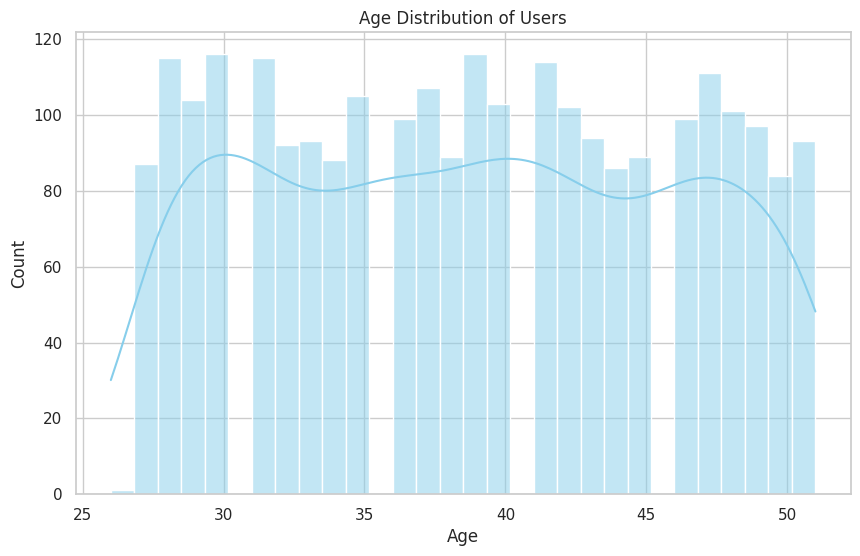

In [29]:
from pyspark.sql.functions import col
# Convert 'Age' column to Pandas DataFrame for plotting
age_distribution_pd = netflix_df.select('Age').toPandas()

# Setting the style for the plots
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(age_distribution_pd['Age'], kde=True, color="skyblue", bins=30)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


# Insight 4: Geographic Distribution of Users
The top 10 countries by user count are:

United States: 451 users

Spain: 451 users

Canada: 317 users

United Kingdom: 183 users

Australia: 183 users

Germany: 183 users

France: 183 users

Brazil: 183 users

Mexico: 183 users

Italy: 183 users

The United States and Spain have the highest number of users among the sampled
data, indicating a significant market presence in these countries. Other
countries like Canada and several European countries also show a good user base.

For the final insight, let's investigate the distribution of users across different devices.

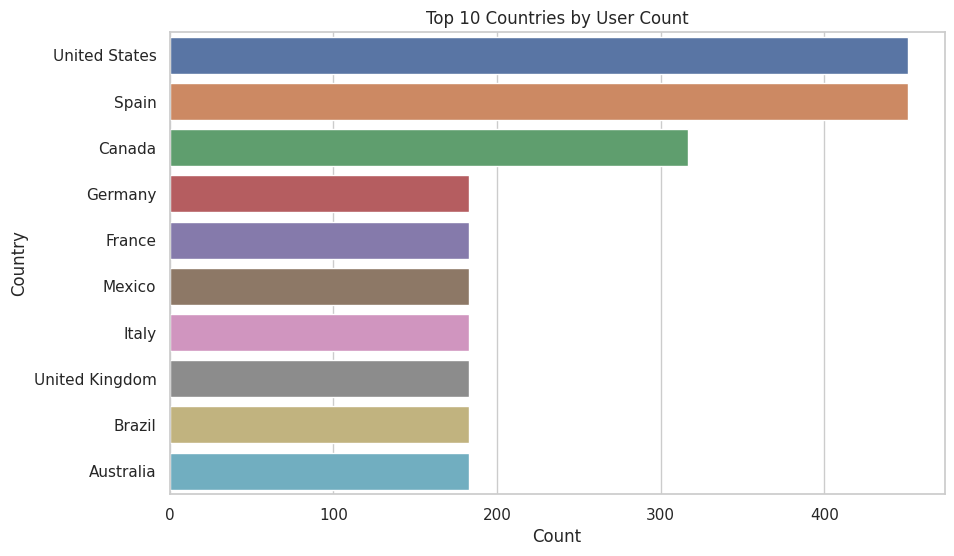

,Country,count
0,United States,451
1,Spain,451
2,Canada,317
3,Germany,183
4,France,183
5,Mexico,183
6,Italy,183
7,United Kingdom,183
8,Brazil,183
9,Australia,183


In [30]:
from pyspark.sql.functions import desc
# Group by 'Country' and calculate user count, then order by count in descending order
country_counts = netflix_df.groupBy('Country').count().orderBy(desc('count')).limit(10)
country_counts_pd = country_counts.toPandas()
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(y="Country", x="count", data=country_counts_pd)
plt.title('Top 10 Countries by User Count')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

country_counts_pd


# Insight 5: Device Distribution among Users
The distribution of users by device is:

Laptop: 636 users
Tablet: 633 users
Smartphone: 621 users
Smart TV: 610 users
The device usage is fairly evenly distributed among Laptop, Tablet, Smartphone, and Smart TV. This indicates a varied preference for streaming devices among users, with no single device dominating significantly.

Now, let's reflect on the tools and methods used during this analysis and discuss the appropriateness of Python and pandas for this task.

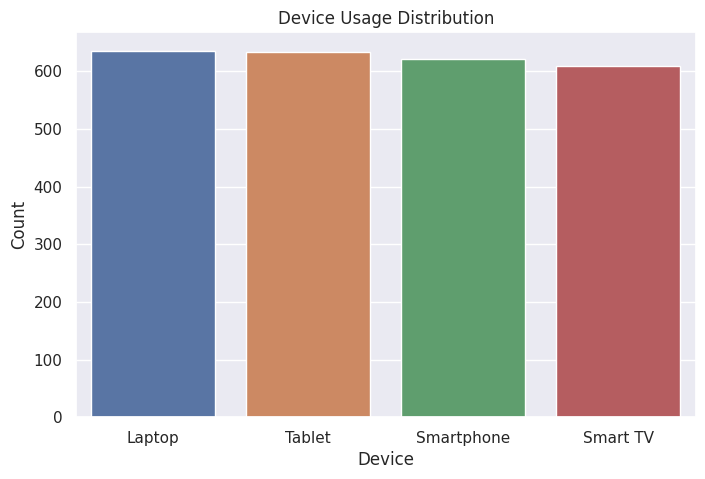

,Device,count
0,Laptop,636
1,Tablet,633
2,Smartphone,621
3,Smart TV,610


from matplotlib import pyplot as plt
device_counts_pd['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
device_counts_pd.groupby('Device').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
device_counts_pd['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(device_counts_pd['Device'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(device_counts_pd, x='count', y='Device', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [33]:
# Group by 'Device' and calculate user count, then order by count in descending order
device_counts = netflix_df.groupBy('Device').count().orderBy(desc('count'))
device_counts_pd = device_counts.toPandas()
sns.set(style="darkgrid")

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x="Device", y="count", data=device_counts_pd)
plt.title('Device Usage Distribution')
plt.xlabel('Device')
plt.ylabel('Count')
plt.show()

device_counts_pd


# **c. Evaluation of Tools and Methods:**

PySpark is a scalable framework that makes use of the Apache Spark engine to process massively dispersed data. Because of its Python integration, it may be used in big data contexts to handle both structured and unstructured data.

Inspired by Pandas, PySpark's DataFrame API provides a familiar interface for manipulating and analyzing data. It allows for the distribution of calculations over a cluster for parallel processing and supports a variety of data sources and formats.

For data visualization, it may also be used in conjunction with Matplotlib and Seaborn, enabling users to produce informative plots and charts for huge datasets. Data scientists and analysts can work together seamlessly because to this connectivity.

# **d. Most Appropriate Programming Language and Tool:**

The project's particular requirements, level of experience, and data volume all have a role in the programming language and tool selection.

Python with modules like Pandas, Matplotlib, and Seaborn offers a stable environment for data analysis and visualization for tiny to medium-sized datasets. They are especially well-known for having many features and being simple to use.

Because PySpark can manage massive data across clusters, it might be a superior option for distributed computing and larger-scale data. That being said, the learning curve is steeper and it is more difficult.

 Python was an effective choice because of its widely used libraries, considering the task's magnitude and complexity.